In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import sys 
import pickle

sys.path.append('../')
import torch
from torch.utils.data import Dataset, DataLoader
from src.config.config import cfg
from src.data.bengali_data import BengaliDataBatchCollator, BengaliDataset

In [3]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

In [4]:
train_path = cfg.DATASET.TRAIN_DATA_PATH
val_path = cfg.DATASET.VAL_DATA_PATH

In [5]:
# DATA LOADER
val_data = pickle.load(open(train_path, 'rb'))
val_dataset = BengaliDataset(val_data, cfg.DATASET, True)

In [6]:
collator = BengaliDataBatchCollator()
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=collator, num_workers=1)

In [7]:
itr = iter(val_loader)

In [11]:
import time
s = time.time()
for i in range(500):
    _ = next(itr)
t = time.time()
print(t-s)

17.256835222244263


Wall time: 0 ns


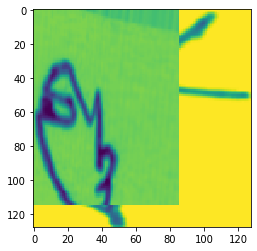

In [9]:
import matplotlib.pyplot as plt
%time 
for i, (xb, yb) in enumerate(itr):   
    #xb, yb = xb.to(device), yb = yb.to(device)
    
    xb, yb = cutmix(xb, yb[:,0], yb[:,1], yb[:,2], 1)
    
    plt.imshow(xb[1][2])
    
    if i == 1: break